In [ ]:
!pip install lightning-utilities
!pip install torchmetrics --no-deps
!pip install torchinfo --no-deps
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 131.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unins

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import time

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import v2
from torchvision.transforms.functional import to_pil_image
from torchmetrics import MeanMetric, Accuracy

from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall, F1Score
from torchinfo import summary
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from torchvision import models

In [ ]:
print(torchvision.__version__)

0.21.0+cu124


In [ ]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Device:", device)

Device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zip_path = '/content/drive/My Drive/archive.zip'
extract_path = '/content/cifake'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to: ", extract_path)

Files extracted to:  /content/cifake


In [ ]:
print("Folders and files in extracted directory:")
print(os.listdir(extract_path))

Folders and files in extracted directory:
['test', 'train']


In [ ]:
def count_all_images(dataset_path):
    total = 0
    for split in ['train', 'test']:
        split_path = os.path.join(dataset_path, split)
        for class_folder in os.listdir(split_path):
            class_path = os.path.join(split_path, class_folder)
            num_images = len(os.listdir(class_path))
            print(f"{split}/{class_folder}: {num_images}")
            total += num_images
    print(f"\nTotal Images: {total}")

count_all_images("/content/cifake")

train/FAKE: 50000
train/REAL: 50000
test/FAKE: 10000
test/REAL: 10000

Total Images: 120000


In [ ]:
from torchvision import datasets

data_dir = '/content/cifake/train'

dataset = datasets.ImageFolder(root=data_dir)

print("کلاس‌ها (برچسب‌ها):", dataset.classes)
print("تعداد نمونه‌ها:", len(dataset))

for path, label in dataset.samples[:5]:
    print(f"تصویر: {os.path.basename(path)}, کلاس: {dataset.classes[label]}")

کلاس‌ها (برچسب‌ها): ['FAKE', 'REAL']
تعداد نمونه‌ها: 100000
تصویر: 1000 (10).jpg, کلاس: FAKE
تصویر: 1000 (2).jpg, کلاس: FAKE
تصویر: 1000 (3).jpg, کلاس: FAKE
تصویر: 1000 (4).jpg, کلاس: FAKE
تصویر: 1000 (5).jpg, کلاس: FAKE


real image:


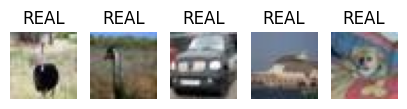

fake image:


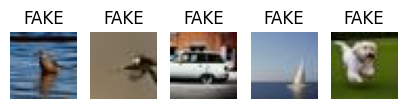

In [ ]:
def show_sample_images(folder, class_name, num=5):
    path = os.path.join(folder, class_name)
    images = os.listdir(path)[:num]

    plt.figure(figsize=(5, 2))
    for i, img_file in enumerate(images):
        img_path = os.path.join(path, img_file)
        img = Image.open(img_path)
        plt.subplot(1, num, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

print("real image:")
show_sample_images("/content/cifake/train", "REAL")

print("fake image:")
show_sample_images("/content/cifake/train", "FAKE")

In [ ]:
dataset.class_to_idx

{'FAKE': 0, 'REAL': 1}

In [ ]:
train_transform = v2.Compose([
    v2.ColorJitter(brightness=0.3, contrast=0.5, saturation=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomResizedCrop(size=224, scale=(0.5, 1.0)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
])

eval_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.data import random_split

full_train_dataset = torchvision.datasets.ImageFolder("/content/cifake/train", transform=train_transform)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=generator)

test_dataset = torchvision.datasets.ImageFolder("/content/cifake/test", transform=eval_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print("classes:", full_train_dataset.classes)
print("train images:", len(train_dataset))
print("validation images:", len(val_dataset))
print("test images:", len(test_dataset))

classes: ['FAKE', 'REAL']
train images: 80000
validation images: 20000
test images: 20000


<ipython-input-78-08eee97ea490>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_dist, x="Class", y="Count", palette="pastel")


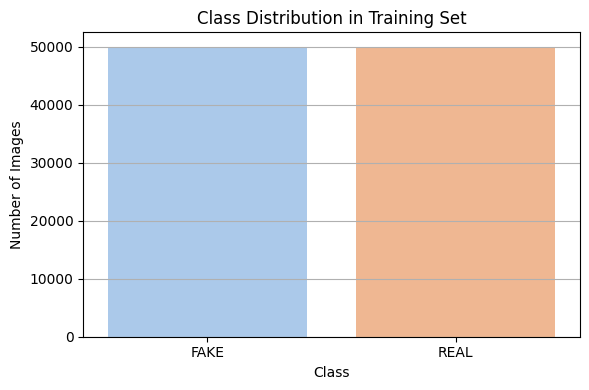

  Class  Count
0  FAKE  50000
1  REAL  50000


In [ ]:
from collections import Counter

dataset_path = "/content/cifake/train"

dataset = datasets.ImageFolder(root=dataset_path)

class_counts = Counter([label for _, label in dataset])

class_names = dataset.classes

class_distribution = {class_names[i]: count for i, count in class_counts.items()}

df_dist = pd.DataFrame(list(class_distribution.items()), columns=["Class", "Count"])

plt.figure(figsize=(6, 4))
sns.barplot(data=df_dist, x="Class", y="Count", palette="pastel")
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

print(df_dist)

In [ ]:
def train_one_epoch_with_val(model, train_loader, val_loader, optimizer, loss_fn):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = correct / total

    model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= total_val
    val_acc = correct_val / total_val

    return train_loss, train_acc, val_loss, val_acc

In [ ]:
from torch.utils.data import Subset

samples_per_class = 6000
targets = [full_train_dataset[i][1] for i in train_dataset.indices]
class_0_indices = [train_dataset.indices[i] for i, y in enumerate(targets) if y == 0]
class_1_indices = [train_dataset.indices[i] for i, y in enumerate(targets) if y == 1]

random.shuffle(class_0_indices)
random.shuffle(class_1_indices)

selected_indices = class_0_indices[:samples_per_class] + class_1_indices[:samples_per_class]
random.shuffle(selected_indices)

balanced_train_set = Subset(full_train_dataset, selected_indices)
balanced_train_loader = torch.utils.data.DataLoader(balanced_train_set, batch_size=32, shuffle=True)

# Part 1 - Simple cnn

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),     # → (N, 32, 224, 224)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                             # → (N, 32, 112, 112)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),    # → (N, 64, 112, 112)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                             # → (N, 64, 56, 56)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),   # → (N, 128, 56, 56)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                             # → (N, 128, 28, 28)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                   # → (N, 128*28*28)
            nn.Dropout(0.5),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),     # → (N, 32, 224, 224)
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(),
#             nn.MaxPool2d(2, 2),                             # → (N, 32, 112, 112)

#             nn.Conv2d(32, 64, kernel_size=3, padding=1),    # → (N, 64, 112, 112)
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(),
#             nn.MaxPool2d(2, 2),                             # → (N, 64, 56, 56)

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),   # → (N, 128, 56, 56)
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(),
#             nn.MaxPool2d(2, 2),                             # → (N, 128, 28, 28)
#         )

#         self.classifier = nn.Sequential(
#             nn.Flatten(),                                   # → (N, 128*28*28)
#             nn.Dropout(0.5),
#             nn.Linear(128 * 28 * 28, 256),
#             nn.LeakyReLU(),
#             nn.Linear(256, 2)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.classifier(x)
#         return x

In [ ]:
# class SimpleCNN(nn.Module):
#     def __init__(self):
#         super(SimpleCNN, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2)
#         )

#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(128 * 28 * 28, 256),
#             nn.ReLU(),
#             nn.Linear(256, 2)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.classifier(x)
#         return x

In [ ]:
simple_model = SimpleCNN().to(device)
simple_optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.0005)
simple_criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 10

cnn_train_losses = []
cnn_train_accuracies = []
cnn_val_losses = []
cnn_val_accuracies = []
simple_train_accuracies = []
simple_val_accuracies = []

best_val_acc = 0.0
best_model_state = None

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()

    train_loss, train_acc, val_loss, val_acc = train_one_epoch_with_val(
        simple_model, balanced_train_loader, val_loader,
        optimizer=simple_optimizer, loss_fn=simple_criterion
    )
    simple_train_accuracies.append(train_acc)
    simple_val_accuracies.append(val_acc)

    cnn_train_losses.append(train_loss)
    cnn_train_accuracies.append(train_acc)
    cnn_val_losses.append(val_loss)
    cnn_val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = simple_model.state_dict()

    print(f"📅 Epoch [{epoch+1}/{num_epochs}]")
    print(f"📘 Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")
    print(f"🧪 Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}")
    print(f"⏱ Time for this epoch: {time.time() - epoch_start:.2f} sec\n")

total_time = time.time() - start_time
print(f"✅ Best Validation Accuracy: {best_val_acc:.4f}")
print(f"🕒 Total Training Time: {total_time:.2f} sec")

torch.save(best_model_state, "best_simplecnn.pth")
print("💾 Best model saved as 'best_simplecnn.pth'")

📅 Epoch [1/10]
📘 Train Loss: 0.7451 | Accuracy: 0.6528
🧪 Val   Loss: 0.5614 | Accuracy: 0.7087
⏱ Time for this epoch: 79.47 sec

📅 Epoch [2/10]
📘 Train Loss: 0.5495 | Accuracy: 0.7162
🧪 Val   Loss: 0.5274 | Accuracy: 0.7289
⏱ Time for this epoch: 79.79 sec

📅 Epoch [3/10]
📘 Train Loss: 0.5176 | Accuracy: 0.7423
🧪 Val   Loss: 0.4824 | Accuracy: 0.7673
⏱ Time for this epoch: 78.41 sec

📅 Epoch [4/10]
📘 Train Loss: 0.4893 | Accuracy: 0.7618
🧪 Val   Loss: 0.5057 | Accuracy: 0.7504
⏱ Time for this epoch: 78.82 sec

📅 Epoch [5/10]
📘 Train Loss: 0.4680 | Accuracy: 0.7788
🧪 Val   Loss: 0.4640 | Accuracy: 0.7806
⏱ Time for this epoch: 78.73 sec

📅 Epoch [6/10]
📘 Train Loss: 0.4557 | Accuracy: 0.7872
🧪 Val   Loss: 0.6353 | Accuracy: 0.6994
⏱ Time for this epoch: 78.58 sec

📅 Epoch [7/10]
📘 Train Loss: 0.4531 | Accuracy: 0.7839
🧪 Val   Loss: 0.4470 | Accuracy: 0.7903
⏱ Time for this epoch: 79.16 sec

📅 Epoch [8/10]
📘 Train Loss: 0.4360 | Accuracy: 0.7972
🧪 Val   Loss: 0.4351 | Accuracy: 0.7971
⏱ 

In [ ]:
# def add_gaussian_noise(images, mean=0.0, std=0.1):
#     noisy_images = images + torch.randn_like(images) * std
#     noisy_images = torch.clamp(noisy_images, 0.0, 1.0)
#     return noisy_images

# # Re-instantiate the model with the same architecture
# simple_model = SimpleCNN().to(device)

# # Load the saved best model weights
# simple_model.load_state_dict(torch.load("best_simplecnn.pth"))
# simple_model.eval()

# # Evaluate on noisy test set
# correct = 0
# total = 0

# with torch.no_grad():
#     for images, labels in test_loader:
#         noisy_images = add_gaussian_noise(images.to(device))
#         labels = labels.to(device)
#         outputs = simple_model(noisy_images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# noisy_accuracy = correct / total
# print(f"📉 Accuracy on noisy test images: {noisy_accuracy:.4f}")

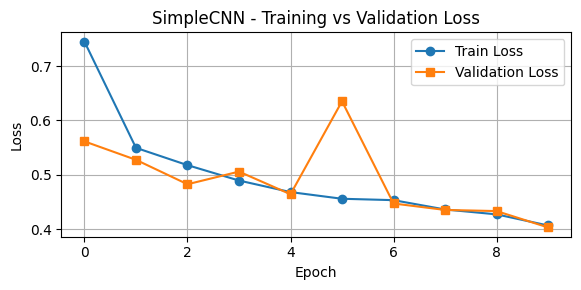

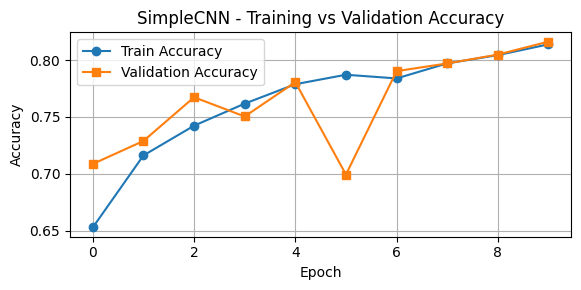

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(cnn_train_losses, label='Train Loss', marker='o')
plt.plot(cnn_val_losses, label='Validation Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SimpleCNN - Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(cnn_train_accuracies, label='Train Accuracy', marker='o')
plt.plot(cnn_val_accuracies, label='Validation Accuracy', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("SimpleCNN - Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("simplecnn_accuracy_loss.png")  # 📌 ذخیره تصویر
plt.show()

In [ ]:
acc = Accuracy(task='multiclass', num_classes=2).to(device)
prec = Precision(task='multiclass', num_classes=2).to(device)
rec = Recall(task='multiclass', num_classes=2).to(device)
f1 = F1Score(task='multiclass', num_classes=2).to(device)
cm = ConfusionMatrix(task='multiclass', num_classes=2).to(device)

acc.reset()
prec.reset()
rec.reset()
f1.reset()
cm.reset()

simple_model.eval()
with torch.no_grad():
    for X, Y in test_loader:
        X, Y = X.to(device), Y.to(device)
        preds = simple_model(X).argmax(dim=1)

        acc.update(preds, Y)
        prec.update(preds, Y)
        rec.update(preds, Y)
        f1.update(preds, Y)
        cm.update(preds, Y)

print("📊 Test Accuracy (SimpleCNN):", acc.compute().item())
print("🎯 Precision:", prec.compute().item())
print("🔁 Recall:", rec.compute().item())
print("📈 F1 Score:", f1.compute().item())

📊 Test Accuracy (SimpleCNN): 0.8320500254631042
🎯 Precision: 0.8320500254631042
🔁 Recall: 0.8320500254631042
📈 F1 Score: 0.8320500254631042


📊 Test Classification Report (Simple CNN):
              precision    recall  f1-score   support

        FAKE       0.77      0.95      0.85     10000
        REAL       0.94      0.71      0.81     10000

    accuracy                           0.83     20000
   macro avg       0.85      0.83      0.83     20000
weighted avg       0.85      0.83      0.83     20000



<ipython-input-89-9a9db3134f88>:21: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


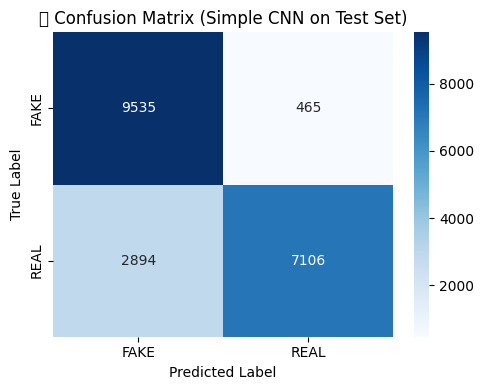

In [ ]:
simple_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, Y in test_loader:
        X, Y = X.to(device), Y.to(device)
        preds = simple_model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(Y.cpu().numpy())

print("📊 Test Classification Report (Simple CNN):")
print(classification_report(all_labels, all_preds, target_names=full_train_dataset.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_train_dataset.classes, yticklabels=full_train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🧮 Confusion Matrix (Simple CNN on Test Set)")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


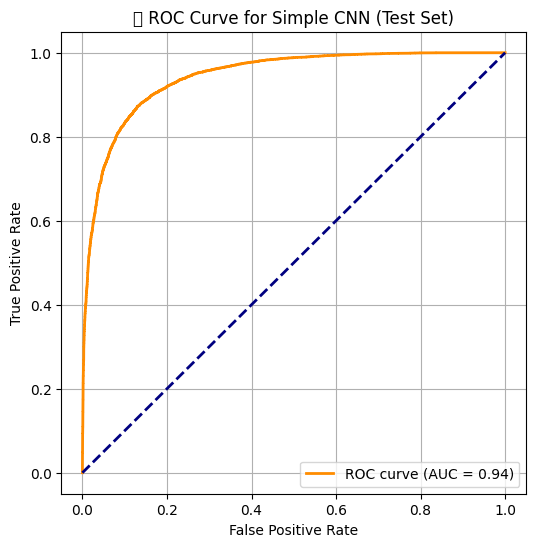

In [ ]:
simple_model.eval()
y_probs = []
y_true = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = simple_model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # احتمال کلاس FAKE
        y_probs.extend(probs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📉 ROC Curve for Simple CNN (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

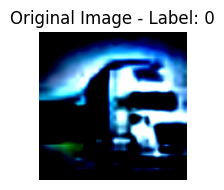

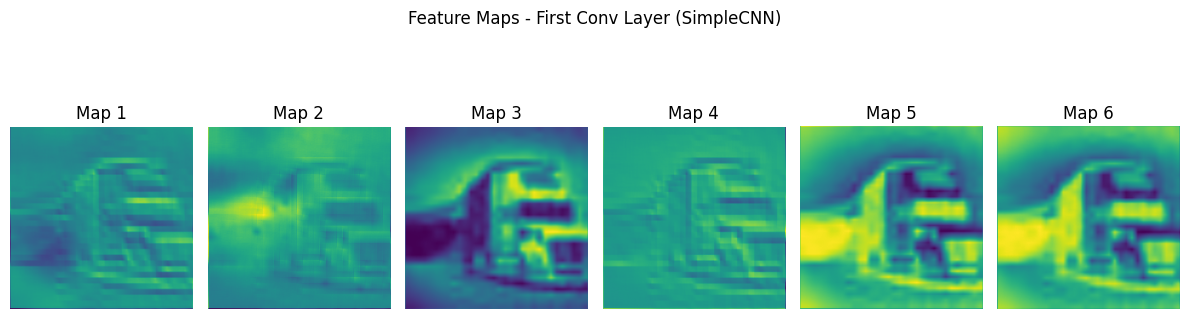

In [ ]:
sample_img, sample_label = test_dataset[0]
sample_input = sample_img.unsqueeze(0).to(device)

plt.figure(figsize=(2, 2))
plt.imshow(sample_img.permute(1, 2, 0).cpu())
plt.title(f"Original Image - Label: {sample_label}")
plt.axis('off')
plt.tight_layout()
plt.show()

with torch.no_grad():
    simple_model.eval()
    feature_maps = simple_model.features[0](sample_input)

feature_maps = feature_maps.squeeze(0).cpu().numpy()

num_maps_to_show = 6
plt.figure(figsize=(12, 4))
for i in range(num_maps_to_show):
    plt.subplot(1, num_maps_to_show, i + 1)
    plt.imshow(feature_maps[i], cmap='viridis')
    plt.title(f"Map {i+1}")
    plt.axis('off')

plt.suptitle("Feature Maps - First Conv Layer (SimpleCNN)")
plt.tight_layout()
plt.show()

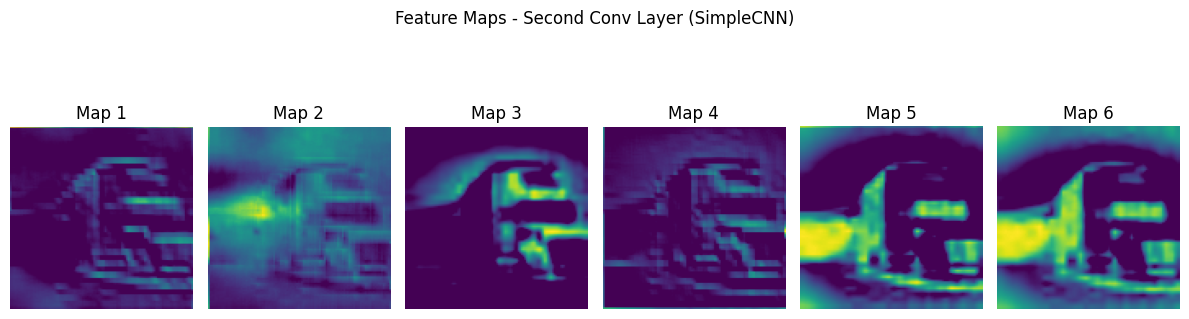

In [ ]:
with torch.no_grad():
    simple_model.eval()
    feature_maps_2 = simple_model.features[:4](sample_input)

feature_maps_2 = feature_maps_2.squeeze(0).cpu().numpy()

num_maps_to_show = 6
plt.figure(figsize=(12, 4))
for i in range(num_maps_to_show):
    plt.subplot(1, num_maps_to_show, i + 1)
    plt.imshow(feature_maps_2[i], cmap='viridis')
    plt.title(f"Map {i+1}")
    plt.axis('off')

plt.suptitle("Feature Maps - Second Conv Layer (SimpleCNN)")
plt.tight_layout()
plt.show()

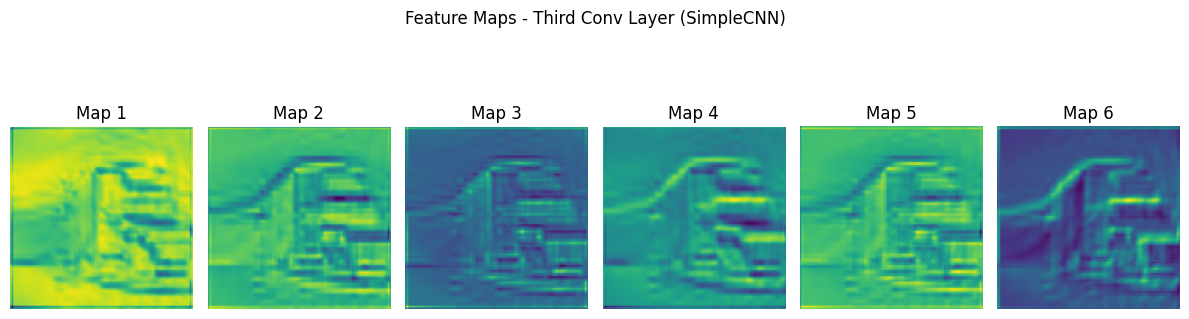

In [ ]:
with torch.no_grad():
    simple_model.eval()
    feature_maps_3 = simple_model.features[:6](sample_input)

feature_maps_3 = feature_maps_3.squeeze(0).cpu().numpy()

num_maps_to_show = 6
plt.figure(figsize=(12, 4))
for i in range(num_maps_to_show):
    plt.subplot(1, num_maps_to_show, i + 1)
    plt.imshow(feature_maps_3[i], cmap='viridis')
    plt.title(f"Map {i+1}")
    plt.axis('off')

plt.suptitle("Feature Maps - Third Conv Layer (SimpleCNN)")
plt.tight_layout()
plt.show()


<ipython-input-94-f179f055a732>:36: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


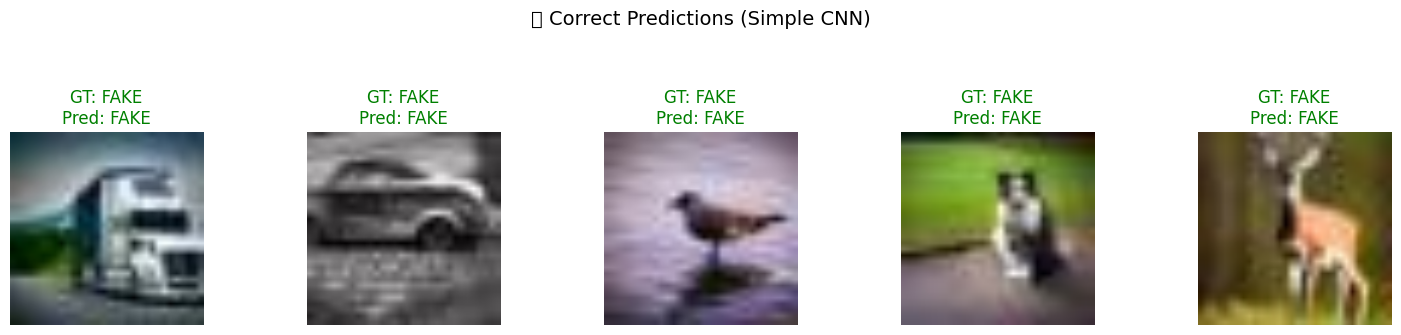

<ipython-input-94-f179f055a732>:36: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


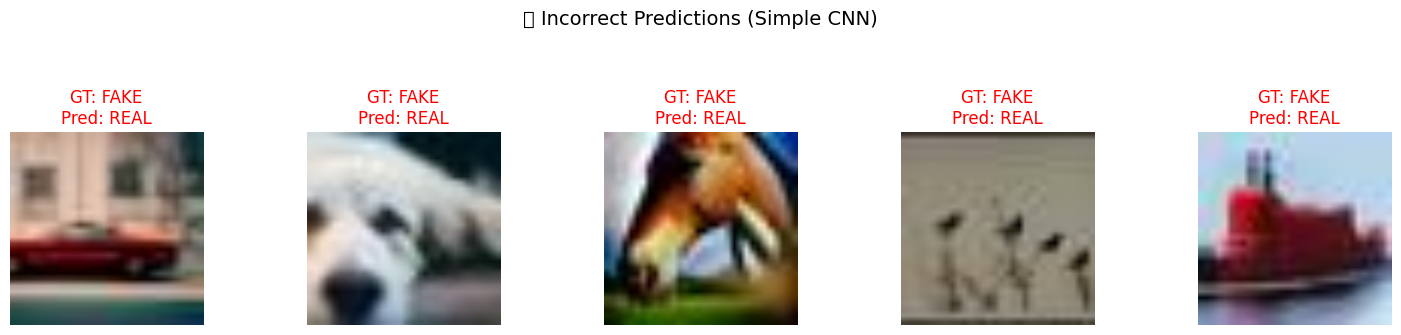

In [ ]:
def show_correct_incorrect_predictions(model, dataset, class_names, n_correct=5, n_wrong=5):
    model.eval()
    correct_images = []
    incorrect_images = []

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

    with torch.no_grad():
        for idx in range(len(dataset)):
            img, label = dataset[idx]
            X = img.unsqueeze(0).to(device)
            pred = model(X).argmax(dim=1).item()

            if pred == label and len(correct_images) < n_correct:
                correct_images.append((img, label, pred))
            elif pred != label and len(incorrect_images) < n_wrong:
                incorrect_images.append((img, label, pred))

            if len(correct_images) >= n_correct and len(incorrect_images) >= n_wrong:
                break

    def plot_images(images, title):
        fig = plt.figure(figsize=(15, 3))
        for i, (img, label, pred) in enumerate(images):
            img_disp = img * std.cpu() + mean.cpu()
            img_disp = img_disp.clamp(0, 1)

            ax = fig.add_subplot(1, len(images), i + 1)
            ax.imshow(img_disp.permute(1, 2, 0).numpy())
            color = 'green' if pred == label else 'red'
            ax.set_title(f"GT: {class_names[label]}\nPred: {class_names[pred]}", color=color)
            ax.axis('off')

        fig.suptitle(title, fontsize=14, y=1.1)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    plot_images(correct_images, "✅ Correct Predictions (Simple CNN)")
    plot_images(incorrect_images, "❌ Incorrect Predictions (Simple CNN)")

test_dataset = test_loader.dataset

show_correct_incorrect_predictions(
    model=simple_model,
    dataset=test_dataset,
    class_names=test_dataset.classes,
    n_correct=5,
    n_wrong=5
)

# Part 2 - RestNet18

In [ ]:
model = models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0005)

In [ ]:
num_epochs = 10
resnet_train_losses = []
resnet_train_accuracies = []
resnet_val_losses = []
resnet_val_accuracies = []
resnet_train_accuracies = []
resnet_val_accuracies = []

best_val_acc_resnet = 0.0
best_model_state_resnet = None

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()

    train_loss, train_acc, val_loss, val_acc = train_one_epoch_with_val(
        model, balanced_train_loader, val_loader, optimizer, criterion
    )
    resnet_train_accuracies.append(train_acc)
    resnet_val_accuracies.append(val_acc)

    resnet_train_losses.append(train_loss)
    resnet_train_accuracies.append(train_acc)
    resnet_val_losses.append(val_loss)
    resnet_val_accuracies.append(val_acc)

    if val_acc > best_val_acc_resnet:
        best_val_acc_resnet = val_acc
        best_model_state_resnet = model.state_dict()
        torch.save(best_model_state_resnet, "best_resnet18.pth")
        print("💾 Best ResNet18 model saved!")

    epoch_time = time.time() - epoch_start
    print(f"📅 Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f} sec")
    print(f"📘 Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")
    print(f"🧪 Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}\n")

total_time = time.time() - start_time
print(f"✅ Best Validation Accuracy (ResNet18): {best_val_acc_resnet:.4f}")
print(f"🕒 Total Training Time: {total_time:.2f} sec")

💾 Best ResNet18 model saved!
📅 Epoch [1/10] - Time: 85.75 sec
📘 Train Loss: 0.5479 | Accuracy: 0.7241
🧪 Val   Loss: 0.4764 | Accuracy: 0.7751

💾 Best ResNet18 model saved!
📅 Epoch [2/10] - Time: 86.23 sec
📘 Train Loss: 0.4702 | Accuracy: 0.7772
🧪 Val   Loss: 0.4449 | Accuracy: 0.7968

💾 Best ResNet18 model saved!
📅 Epoch [3/10] - Time: 85.55 sec
📘 Train Loss: 0.4470 | Accuracy: 0.7897
🧪 Val   Loss: 0.4380 | Accuracy: 0.8000

💾 Best ResNet18 model saved!
📅 Epoch [4/10] - Time: 86.11 sec
📘 Train Loss: 0.4471 | Accuracy: 0.7912
🧪 Val   Loss: 0.4253 | Accuracy: 0.8047

📅 Epoch [5/10] - Time: 85.86 sec
📘 Train Loss: 0.4460 | Accuracy: 0.7923
🧪 Val   Loss: 0.4298 | Accuracy: 0.8027

💾 Best ResNet18 model saved!
📅 Epoch [6/10] - Time: 86.40 sec
📘 Train Loss: 0.4407 | Accuracy: 0.7922
🧪 Val   Loss: 0.4167 | Accuracy: 0.8082

📅 Epoch [7/10] - Time: 85.70 sec
📘 Train Loss: 0.4349 | Accuracy: 0.7992
🧪 Val   Loss: 0.4329 | Accuracy: 0.7976

💾 Best ResNet18 model saved!
📅 Epoch [8/10] - Time: 85.96

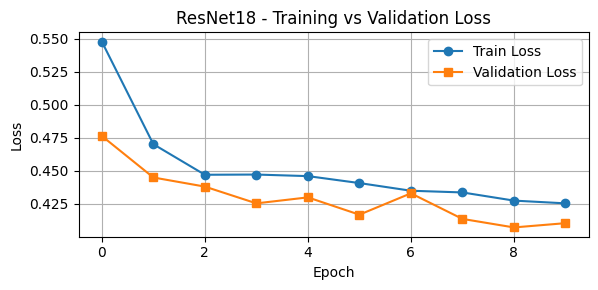

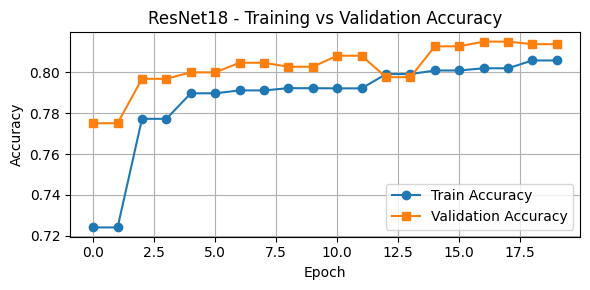

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(resnet_train_losses, label='Train Loss', marker='o')
plt.plot(resnet_val_losses, label='Validation Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet18 - Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(resnet_train_accuracies, label='Train Accuracy', marker='o')
plt.plot(resnet_val_accuracies, label='Validation Accuracy', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet18 - Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("resnet18_accuracy_loss.png")
plt.show()

📊 Test Accuracy (ResNet18): 0.8151000142097473
🎯 Precision: 0.8151000142097473
🔁 Recall: 0.8151000142097473
📈 F1 Score: 0.8151000142097473


<ipython-input-99-bafcd39e1ae1>:40: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


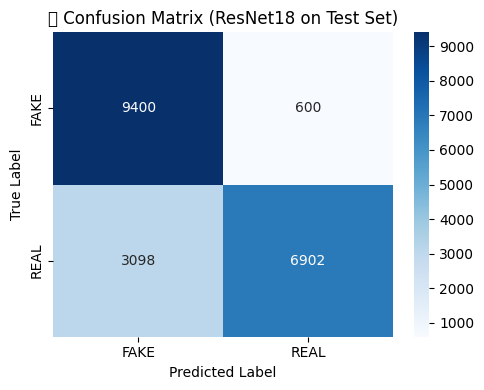

In [ ]:
resnet_model = models.resnet18(weights='IMAGENET1K_V1')
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 2)
resnet_model.load_state_dict(torch.load("best_resnet18.pth"))
resnet_model = resnet_model.to(device)
resnet_model.eval()

acc_resnet = Accuracy(task='multiclass', num_classes=2).to(device)
prec_resnet = Precision(task='multiclass', num_classes=2).to(device)
rec_resnet = Recall(task='multiclass', num_classes=2).to(device)
f1_resnet = F1Score(task='multiclass', num_classes=2).to(device)
cm_resnet = ConfusionMatrix(task='multiclass', num_classes=2).to(device)

for metric in [acc_resnet, prec_resnet, rec_resnet, f1_resnet, cm_resnet]:
    metric.reset()

with torch.no_grad():
    for X, Y in test_loader:
        X, Y = X.to(device), Y.to(device)
        preds = resnet_model(X).argmax(dim=1)

        acc_resnet.update(preds, Y)
        prec_resnet.update(preds, Y)
        rec_resnet.update(preds, Y)
        f1_resnet.update(preds, Y)
        cm_resnet.update(preds, Y)

print("📊 Test Accuracy (ResNet18):", acc_resnet.compute().item())
print("🎯 Precision:", prec_resnet.compute().item())
print("🔁 Recall:", rec_resnet.compute().item())
print("📈 F1 Score:", f1_resnet.compute().item())

cm_array = cm_resnet.compute().cpu().numpy()
plt.figure(figsize=(5, 4))
sns.heatmap(cm_array, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_train_dataset.classes,
            yticklabels=full_train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🧮 Confusion Matrix (ResNet18 on Test Set)")
plt.tight_layout()
plt.show()

📊 Test Classification Report (ResNet18):
              precision    recall  f1-score   support

        FAKE       0.75      0.94      0.84     10000
        REAL       0.92      0.69      0.79     10000

    accuracy                           0.82     20000
   macro avg       0.84      0.82      0.81     20000
weighted avg       0.84      0.82      0.81     20000



<ipython-input-100-a46caa5b4e66>:24: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


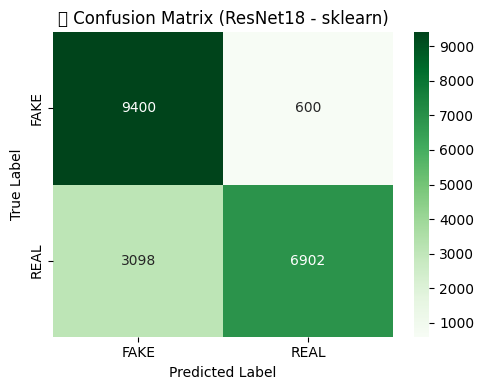

In [ ]:
resnet_model.eval()
all_preds_resnet = []
all_labels_resnet = []

with torch.no_grad():
    for X, Y in test_loader:
        X, Y = X.to(device), Y.to(device)
        preds = resnet_model(X).argmax(dim=1)
        all_preds_resnet.extend(preds.cpu().numpy())
        all_labels_resnet.extend(Y.cpu().numpy())

print("📊 Test Classification Report (ResNet18):")
print(classification_report(all_labels_resnet, all_preds_resnet, target_names=full_train_dataset.classes))

cm_resnet_sklearn = confusion_matrix(all_labels_resnet, all_preds_resnet)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_resnet_sklearn, annot=True, fmt='d', cmap='Greens',
            xticklabels=full_train_dataset.classes,
            yticklabels=full_train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🧮 Confusion Matrix (ResNet18 - sklearn)")
plt.tight_layout()
plt.show()

<ipython-input-101-daf3bba05b34>:25: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


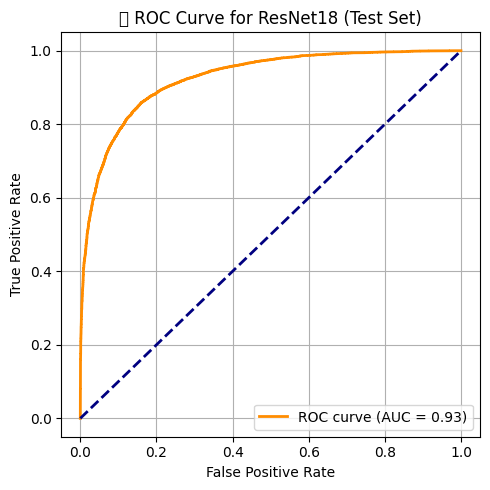

In [ ]:
resnet_model.eval()
y_probs_resnet = []
y_true_resnet = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet_model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        y_probs_resnet.extend(probs.cpu().numpy())
        y_true_resnet.extend(labels.cpu().numpy())

fpr_resnet, tpr_resnet, _ = roc_curve(y_true_resnet, y_probs_resnet)
roc_auc_resnet = auc(fpr_resnet, tpr_resnet)

plt.figure(figsize=(5, 5))
plt.plot(fpr_resnet, tpr_resnet, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc_resnet:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📉 ROC Curve for ResNet18 (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-102-25758941eef2>:36: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


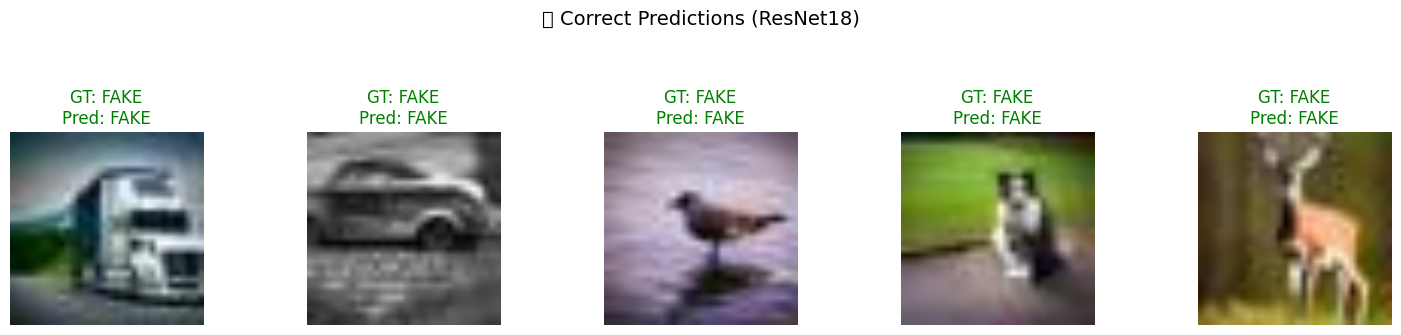

<ipython-input-102-25758941eef2>:36: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


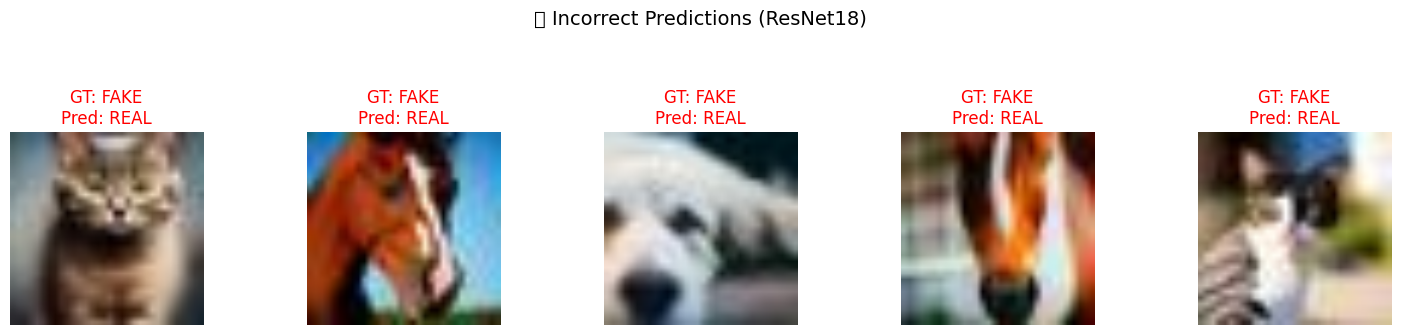

In [ ]:
def show_correct_incorrect_predictions(model, dataset, class_names, n_correct=5, n_wrong=5):
    model.eval()
    correct_images = []
    incorrect_images = []

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

    with torch.no_grad():
        for idx in range(len(dataset)):
            img, label = dataset[idx]
            X = img.unsqueeze(0).to(device)
            pred = model(X).argmax(dim=1).item()

            if pred == label and len(correct_images) < n_correct:
                correct_images.append((img, label, pred))
            elif pred != label and len(incorrect_images) < n_wrong:
                incorrect_images.append((img, label, pred))

            if len(correct_images) >= n_correct and len(incorrect_images) >= n_wrong:
                break

    def plot_images(images, title):
        fig = plt.figure(figsize=(15, 3))
        for i, (img, label, pred) in enumerate(images):
            img_disp = img * std.cpu() + mean.cpu()
            img_disp = img_disp.clamp(0, 1)

            ax = fig.add_subplot(1, len(images), i + 1)
            ax.imshow(img_disp.permute(1, 2, 0).numpy())
            color = 'green' if pred == label else 'red'
            ax.set_title(f"GT: {class_names[label]}\nPred: {class_names[pred]}", color=color)
            ax.axis('off')

        fig.suptitle(title, fontsize=14, y=1.1)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    plot_images(correct_images, "✅ Correct Predictions (ResNet18)")
    plot_images(incorrect_images, "❌ Incorrect Predictions (ResNet18)")

test_dataset = test_loader.dataset
show_correct_incorrect_predictions(
    model=resnet_model,
    dataset=test_dataset,
    class_names=test_dataset.classes,
    n_correct=5,
    n_wrong=5
)

# Part 3 – EfficientNetV2-S

In [ ]:
import timm

efficientnetv2 = timm.create_model('tf_efficientnetv2_s_in21k', pretrained=True)

num_features = efficientnetv2.get_classifier().in_features
efficientnetv2.classifier = nn.Linear(num_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnetv2 = efficientnetv2.to(device)

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name tf_efficientnetv2_s_in21k to current tf_efficientnetv2_s.in21k.
  model = create_fn(


In [ ]:
criterion_effnet = nn.CrossEntropyLoss()
optimizer_effnet = torch.optim.Adam(efficientnetv2.classifier.parameters(), lr=0.0005)

In [ ]:
num_epochs = 10
effnet_train_losses, effnet_train_accuracies = [], []
effnet_val_losses, effnet_val_accuracies = [], []


best_val_acc_effnet = 0.0
best_model_state_effnet = None

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    efficientnetv2.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in balanced_train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_effnet.zero_grad()
        outputs = efficientnetv2(images)
        loss = criterion_effnet(outputs, labels)
        loss.backward()
        optimizer_effnet.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    effnet_train_losses.append(train_loss)
    effnet_train_accuracies.append(train_acc)

    efficientnetv2.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = efficientnetv2(images)
            loss = criterion_effnet(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    effnet_val_losses.append(val_loss)
    effnet_val_accuracies.append(val_acc)

    effnet_train_accuracies.append(train_acc)
    effnet_val_accuracies.append(val_acc)

    if val_acc > best_val_acc_effnet:
        best_val_acc_effnet = val_acc
        best_model_state_effnet = efficientnetv2.state_dict()
        torch.save(best_model_state_effnet, "best_effnetv2.pth")
        print("💾 Best EfficientNetV2 model saved!")

    duration = time.time() - epoch_start
    print(f"📅 Epoch [{epoch+1}/{num_epochs}] - Time: {duration:.2f} sec")
    print(f"📘 Train Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")
    print(f"🧪 Val   Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}\n")

total_training_time = time.time() - start_time
print(f"✅ Best Validation Accuracy (EffNetV2): {best_val_acc_effnet:.4f}")
print(f"🕒 Total Training Time: {total_training_time:.2f} sec")

💾 Best EfficientNetV2 model saved!
📅 Epoch [1/10] - Time: 217.32 sec
📘 Train Loss: 0.4616 | Accuracy: 0.7823
🧪 Val   Loss: 0.3868 | Accuracy: 0.8293

💾 Best EfficientNetV2 model saved!
📅 Epoch [2/10] - Time: 216.75 sec
📘 Train Loss: 0.4038 | Accuracy: 0.8167
🧪 Val   Loss: 0.3686 | Accuracy: 0.8353

💾 Best EfficientNetV2 model saved!
📅 Epoch [3/10] - Time: 217.00 sec
📘 Train Loss: 0.3756 | Accuracy: 0.8311
🧪 Val   Loss: 0.3644 | Accuracy: 0.8389

💾 Best EfficientNetV2 model saved!
📅 Epoch [4/10] - Time: 216.79 sec
📘 Train Loss: 0.3860 | Accuracy: 0.8261
🧪 Val   Loss: 0.3512 | Accuracy: 0.8460

💾 Best EfficientNetV2 model saved!
📅 Epoch [5/10] - Time: 216.61 sec
📘 Train Loss: 0.3736 | Accuracy: 0.8308
🧪 Val   Loss: 0.3508 | Accuracy: 0.8476

💾 Best EfficientNetV2 model saved!
📅 Epoch [6/10] - Time: 216.74 sec
📘 Train Loss: 0.3667 | Accuracy: 0.8389
🧪 Val   Loss: 0.3520 | Accuracy: 0.8479

📅 Epoch [7/10] - Time: 217.42 sec
📘 Train Loss: 0.3614 | Accuracy: 0.8403
🧪 Val   Loss: 0.3573 | Acc

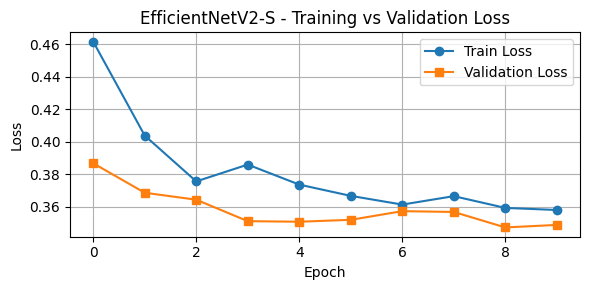

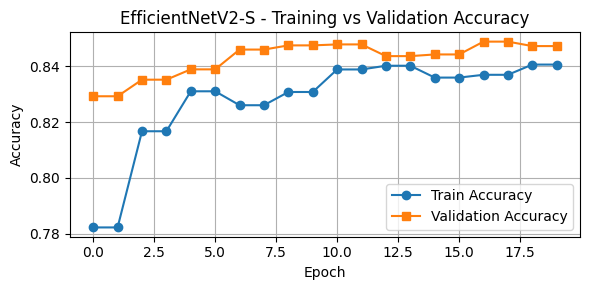

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(effnet_train_losses, label='Train Loss', marker='o')
plt.plot(effnet_val_losses, label='Validation Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("EfficientNetV2-S - Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(effnet_train_accuracies, label='Train Accuracy', marker='o')
plt.plot(effnet_val_accuracies, label='Validation Accuracy', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("EfficientNetV2-S - Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("effnetv2_accuracy_loss.png")
plt.show()

📊 Test Accuracy (EfficientNetV2-S): 0.8555499911308289
🎯 Precision: 0.8555499911308289
🔁 Recall: 0.8555499911308289
📈 F1 Score: 0.8555499911308289


<ipython-input-107-342916630b55>:40: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


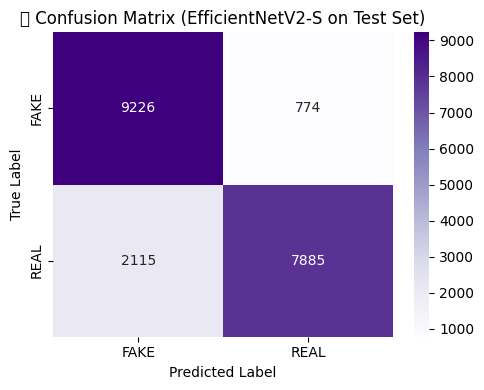

In [ ]:
effnet_model = timm.create_model('tf_efficientnetv2_s_in21k', pretrained=False)
effnet_model.classifier = nn.Linear(effnet_model.get_classifier().in_features, 2)
effnet_model.load_state_dict(torch.load("best_effnetv2.pth"))
effnet_model = effnet_model.to(device)
effnet_model.eval()

acc_effnet = Accuracy(task='multiclass', num_classes=2).to(device)
prec_effnet = Precision(task='multiclass', num_classes=2).to(device)
rec_effnet = Recall(task='multiclass', num_classes=2).to(device)
f1_effnet = F1Score(task='multiclass', num_classes=2).to(device)
cm_effnet = ConfusionMatrix(task='multiclass', num_classes=2).to(device)

for metric in [acc_effnet, prec_effnet, rec_effnet, f1_effnet, cm_effnet]:
    metric.reset()

with torch.no_grad():
    for X, Y in test_loader:
        X, Y = X.to(device), Y.to(device)
        preds = effnet_model(X).argmax(dim=1)

        acc_effnet.update(preds, Y)
        prec_effnet.update(preds, Y)
        rec_effnet.update(preds, Y)
        f1_effnet.update(preds, Y)
        cm_effnet.update(preds, Y)

print("📊 Test Accuracy (EfficientNetV2-S):", acc_effnet.compute().item())
print("🎯 Precision:", prec_effnet.compute().item())
print("🔁 Recall:", rec_effnet.compute().item())
print("📈 F1 Score:", f1_effnet.compute().item())

cm_array = cm_effnet.compute().cpu().numpy()
plt.figure(figsize=(5, 4))
sns.heatmap(cm_array, annot=True, fmt='d', cmap='Purples',
            xticklabels=full_train_dataset.classes,
            yticklabels=full_train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🧮 Confusion Matrix (EfficientNetV2-S on Test Set)")
plt.tight_layout()
plt.show()

📊 Test Classification Report (EfficientNetV2-S):
              precision    recall  f1-score   support

        FAKE       0.81      0.92      0.86     10000
        REAL       0.91      0.79      0.85     10000

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.85     20000
weighted avg       0.86      0.86      0.85     20000



<ipython-input-108-a59a2cd4d407>:23: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


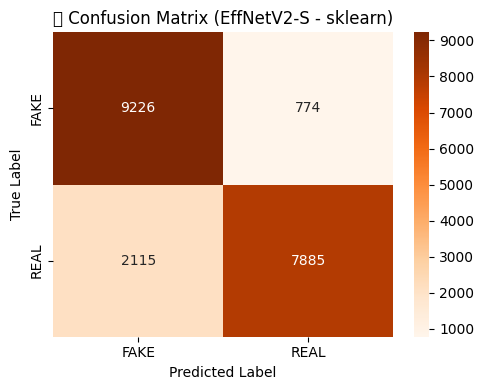

In [ ]:
effnet_model.eval()
all_preds_effnet = []
all_labels_effnet = []

with torch.no_grad():
    for X, Y in test_loader:
        X, Y = X.to(device), Y.to(device)
        preds = effnet_model(X).argmax(dim=1)
        all_preds_effnet.extend(preds.cpu().numpy())
        all_labels_effnet.extend(Y.cpu().numpy())

print("📊 Test Classification Report (EfficientNetV2-S):")
print(classification_report(all_labels_effnet, all_preds_effnet, target_names=full_train_dataset.classes))

cm_sklearn_effnet = confusion_matrix(all_labels_effnet, all_preds_effnet)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_sklearn_effnet, annot=True, fmt='d', cmap='Oranges',
            xticklabels=full_train_dataset.classes,
            yticklabels=full_train_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🧮 Confusion Matrix (EffNetV2-S - sklearn)")
plt.tight_layout()
plt.show()

<ipython-input-109-37509bbc0494>:23: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


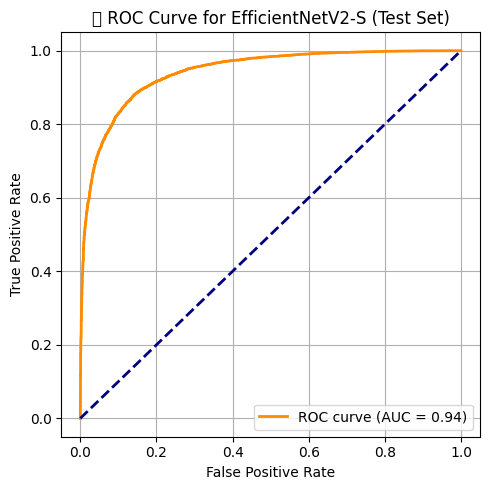

In [ ]:
y_probs_effnet = []
y_true_effnet = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = effnet_model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        y_probs_effnet.extend(probs.cpu().numpy())
        y_true_effnet.extend(labels.cpu().numpy())

fpr_effnet, tpr_effnet, _ = roc_curve(y_true_effnet, y_probs_effnet)
roc_auc_effnet = auc(fpr_effnet, tpr_effnet)

plt.figure(figsize=(5, 5))
plt.plot(fpr_effnet, tpr_effnet, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc_effnet:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📉 ROC Curve for EfficientNetV2-S (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-110-3b22c3a220a9>:36: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


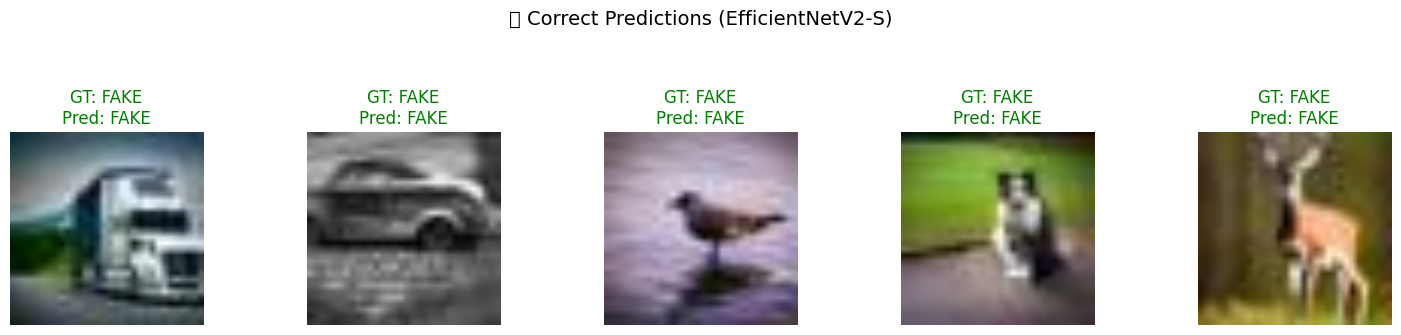

<ipython-input-110-3b22c3a220a9>:36: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


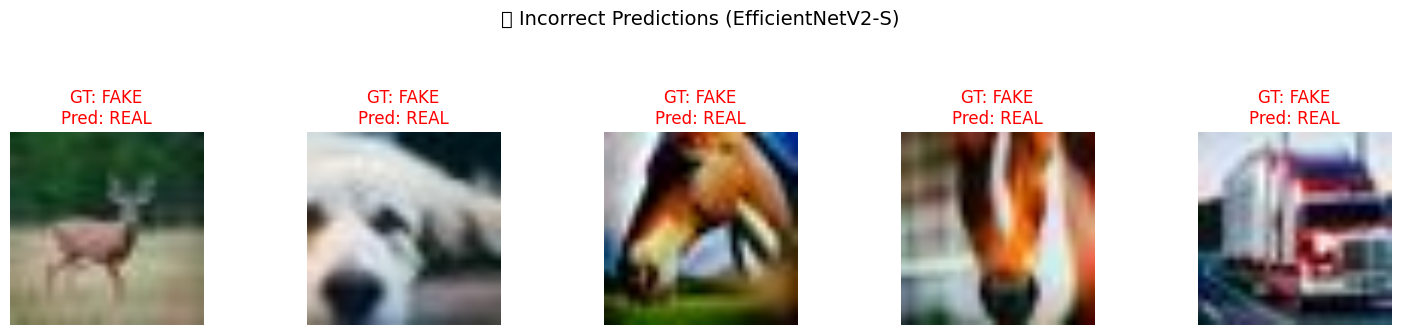

In [ ]:
def show_correct_incorrect_predictions(model, dataset, class_names, n_correct=5, n_wrong=5):
    model.eval()
    correct_images = []
    incorrect_images = []

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

    with torch.no_grad():
        for idx in range(len(dataset)):
            img, label = dataset[idx]
            X = img.unsqueeze(0).to(device)
            pred = model(X).argmax(dim=1).item()

            if pred == label and len(correct_images) < n_correct:
                correct_images.append((img, label, pred))
            elif pred != label and len(incorrect_images) < n_wrong:
                incorrect_images.append((img, label, pred))

            if len(correct_images) >= n_correct and len(incorrect_images) >= n_wrong:
                break

    def plot_images(images, title):
        fig = plt.figure(figsize=(15, 3))
        for i, (img, label, pred) in enumerate(images):
            img_disp = img * std.cpu() + mean.cpu()
            img_disp = img_disp.clamp(0, 1)

            ax = fig.add_subplot(1, len(images), i + 1)
            ax.imshow(img_disp.permute(1, 2, 0).numpy())
            color = 'green' if pred == label else 'red'
            ax.set_title(f"GT: {class_names[label]}\nPred: {class_names[pred]}", color=color)
            ax.axis('off')

        fig.suptitle(title, fontsize=14, y=1.1)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    plot_images(correct_images, "✅ Correct Predictions (EfficientNetV2-S)")
    plot_images(incorrect_images, "❌ Incorrect Predictions (EfficientNetV2-S)")

test_dataset = test_loader.dataset

show_correct_incorrect_predictions(
    model=effnet_model,
    dataset=test_dataset,
    class_names=test_dataset.classes,
    n_correct=5,
    n_wrong=5
)

# Comparison of 3 Models

In [ ]:
# --- SimpleCNN ---
y_true_cnn = []
y_probs_cnn = []
simple_model.eval()

with torch.no_grad():
    for X, Y in test_loader:
        X, Y = X.to(device), Y.to(device)
        outputs = simple_model(X)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        y_probs_cnn.extend(probs.cpu().numpy())
        y_true_cnn.extend(Y.cpu().numpy())

# --- ResNet18 ---
y_true_resnet = []
y_probs_resnet = []
resnet_model.eval()

with torch.no_grad():
    for X, Y in test_loader:
        X, Y = X.to(device), Y.to(device)
        outputs = resnet_model(X)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        y_probs_resnet.extend(probs.cpu().numpy())
        y_true_resnet.extend(Y.cpu().numpy())

# --- EfficientNetV2-S ---
y_true_effnet = []
y_probs_effnet = []
effnet_model.eval()

with torch.no_grad():
    for X, Y in test_loader:
        X, Y = X.to(device), Y.to(device)
        outputs = effnet_model(X)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        y_probs_effnet.extend(probs.cpu().numpy())
        y_true_effnet.extend(Y.cpu().numpy())

<ipython-input-112-c00d1de79063>:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


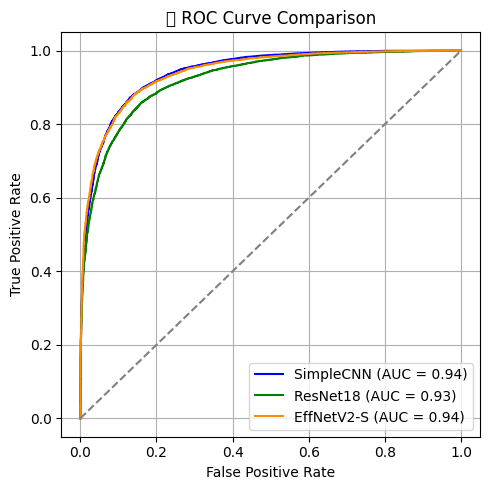

In [ ]:
fpr_cnn, tpr_cnn, _ = roc_curve(y_true_cnn, y_probs_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

fpr_resnet, tpr_resnet, _ = roc_curve(y_true_resnet, y_probs_resnet)
roc_auc_resnet = auc(fpr_resnet, tpr_resnet)

fpr_effnet, tpr_effnet, _ = roc_curve(y_true_effnet, y_probs_effnet)
roc_auc_effnet = auc(fpr_effnet, tpr_effnet)

plt.figure(figsize=(5, 5))
plt.plot(fpr_cnn, tpr_cnn, label=f"SimpleCNN (AUC = {roc_auc_cnn:.2f})", color="blue")
plt.plot(fpr_resnet, tpr_resnet, label=f"ResNet18 (AUC = {roc_auc_resnet:.2f})", color="green")
plt.plot(fpr_effnet, tpr_effnet, label=f"EffNetV2-S (AUC = {roc_auc_effnet:.2f})", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📊 ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

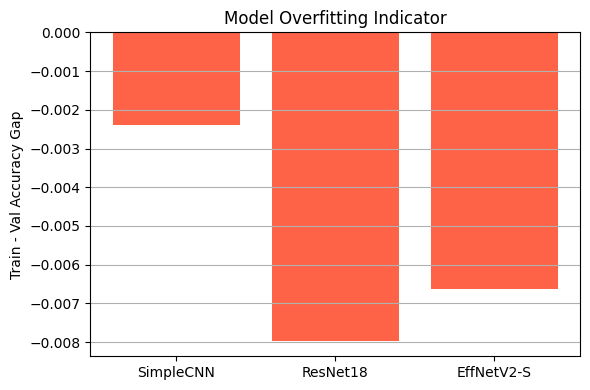

SimpleCNN gap: -0.0024
ResNet18 gap: -0.0080
EffNetV2-S gap: -0.0066


In [ ]:
gap_simplecnn = simple_train_accuracies[-1] - simple_val_accuracies[-1]
gap_resnet = resnet_train_accuracies[-1] - resnet_val_accuracies[-1]
gap_effnet = effnet_train_accuracies[-1] - effnet_val_accuracies[-1]

acc_gap = [gap_simplecnn, gap_resnet, gap_effnet]
models = ["SimpleCNN", "ResNet18", "EffNetV2-S"]

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(models, acc_gap, color='tomato')
plt.ylabel("Train - Val Accuracy Gap")
plt.title("Model Overfitting Indicator")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

for model, gap in zip(models, acc_gap):
    print(f"{model} gap: {gap:.4f}")

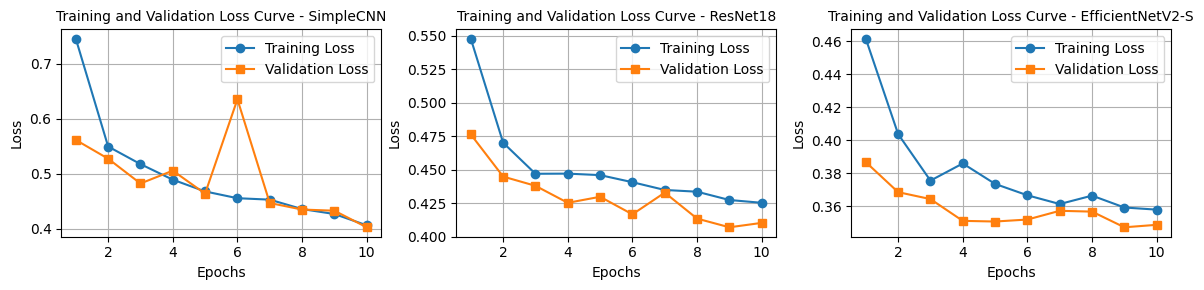

In [ ]:
# داده‌های Loss مدل SimpleCNN
cnn_train_losses = [0.7451, 0.5495, 0.5176, 0.4893, 0.4680, 0.4557, 0.4531, 0.4360, 0.4270, 0.4065]
cnn_val_losses =   [0.5614, 0.5274, 0.4824, 0.5057, 0.4640, 0.6353, 0.4470, 0.4351, 0.4330, 0.4029]

# داده‌های Loss مدل ResNet18
resnet_train_losses = [0.5479, 0.4702, 0.4470, 0.4471, 0.4460, 0.4407, 0.4349, 0.4336, 0.4274, 0.4253]
resnet_val_losses =   [0.4764, 0.4449, 0.4380, 0.4253, 0.4298, 0.4167, 0.4329, 0.4135, 0.4070, 0.4103]

# داده‌های Loss مدل EfficientNetV2-S
effnet_train_losses = [0.4616, 0.4038, 0.3756, 0.3860, 0.3736, 0.3667, 0.3614, 0.3665, 0.3593, 0.3580]
effnet_val_losses =   [0.3868, 0.3686, 0.3644, 0.3512, 0.3508, 0.3520, 0.3573, 0.3568, 0.3473, 0.3488]

# تعداد epoch ها برای هر مدل
epochs_cnn = range(1, len(cnn_train_losses) + 1)
epochs_resnet = range(1, len(resnet_train_losses) + 1)
epochs_effnet = range(1, len(effnet_train_losses) + 1)

fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# نمودار Loss مدل SimpleCNN
axs[0].plot(epochs_cnn, cnn_train_losses, label='Training Loss', marker='o')
axs[0].plot(epochs_cnn, cnn_val_losses, label='Validation Loss', marker='s')
axs[0].set_title('Training and Validation Loss Curve - SimpleCNN', fontsize=10)
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# نمودار Loss مدل ResNet18
axs[1].plot(epochs_resnet, resnet_train_losses, label='Training Loss', marker='o')
axs[1].plot(epochs_resnet, resnet_val_losses, label='Validation Loss', marker='s')
axs[1].set_title('Training and Validation Loss Curve - ResNet18', fontsize=10)
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# نمودار Loss مدل EfficientNetV2-S
axs[2].plot(epochs_effnet, effnet_train_losses, label='Training Loss', marker='o')
axs[2].plot(epochs_effnet, effnet_val_losses, label='Validation Loss', marker='s')
axs[2].set_title('Training and Validation Loss Curve - EfficientNetV2-S', fontsize=10)
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

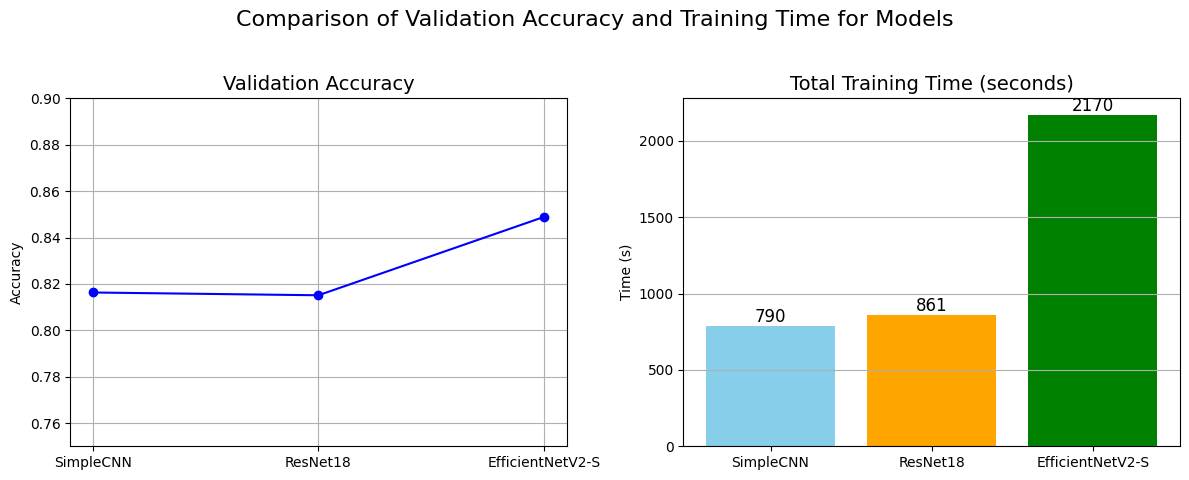

In [ ]:
# مقادیر جدید بر اساس نتایج واقعی مدل‌ها
val_acc = {
    'SimpleCNN': 0.8163,
    'ResNet18': 0.8151,
    'EfficientNetV2-S': 0.8489
}

training_time_sec = {
    'SimpleCNN': 790.04,
    'ResNet18': 860.76,
    'EfficientNetV2-S': 2169.63
}

models = list(val_acc.keys())
val_acc_values = list(val_acc.values())
training_time_values = list(training_time_sec.values())

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# نمودار دقت اعتبارسنجی (Validation Accuracy)
axs[0].plot(models, val_acc_values, marker='o', linestyle='-', color='blue')
axs[0].set_title('Validation Accuracy', fontsize=14)
axs[0].set_ylim([0.75, 0.9])
axs[0].set_ylabel('Accuracy')
axs[0].grid(True)

# نمودار میله‌ای زمان آموزش
bars = axs[1].bar(models, training_time_values, color=['skyblue', 'orange', 'green'])
axs[1].set_title('Total Training Time (seconds)', fontsize=14)
axs[1].set_ylabel('Time (s)')
axs[1].grid(axis='y')

for bar in bars:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2, height, f'{height:.0f}',
                ha='center', va='bottom', fontsize=12)

plt.suptitle('Comparison of Validation Accuracy and Training Time for Models', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# AI Application

In [1]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.0 MB/s eta 0:00:00


In [ ]:
import gradio as gr
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F

# Define class labels
class_names = ['REAL', 'FAKE']

# Transformation for test image (same as used during testing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Prediction function
def predict(image):
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to GPU
    simple_model.eval()
    with torch.no_grad():
        outputs = simple_model(image)
        probs = F.softmax(outputs, dim=1).cpu().numpy().flatten()
    result = {class_names[i]: float(probs[i]) for i in range(2)}
    return result

# Launch Gradio app
gr.Interface(fn=predict,
             inputs=gr.Image(type="pil"),
             outputs=gr.Label(num_top_classes=2),
             title="Deepfake Detection App",
             description="Upload an image to detect whether it's REAL or FAKE using SimpleCNN model."
).launch(debug=True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://148c4d9982e111c34a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
